In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)

In [3]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

transform = np.array([[1, 0, 0],
                      [0, 0, -1],
                      [0, 1, 0]])
controller.set_transform(transform)

start_point = controller.get_sensor_pose()[0:3]

In [4]:
import time
from tools.measuring import MeasuringInterface
measuring_interface = MeasuringInterface(controller)

In [5]:
measuring_interface.start_measuring("tmp")
time.sleep(1)
measuring_interface.stop_measuring()

('stop',)


In [6]:
# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1], 0.005)[2] 
controller.move_absolute(start_point[0:3])

depth = top_point_z - start_point[2] - 0.008

# Double X points
controller.move_relative([0.02, 0.003, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, -depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.02, 0, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0], 0.005)[0:2]
controller.move_relative([-0.005, 0, -depth])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0], 0.005)[0:2]
controller.move_relative([0, 0.005, -depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1])

Width x: 0.023830653891511247, width y: 0


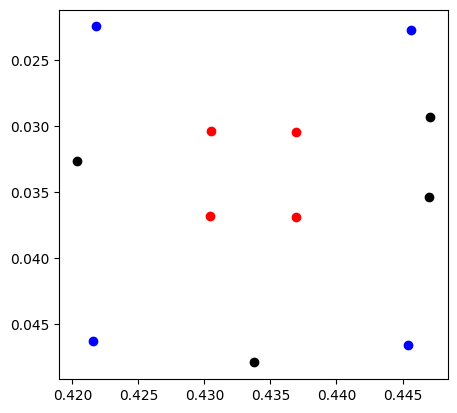

In [9]:
from tools.helpers import *
import matplotlib.pyplot as plt

tool_width = 0.003 / 2 # We want radius
pitch = 0.0065
# 7mm for my design, 6mm for remko design
offset = (0.0055 + pitch / 2, 0.0063 + pitch / 2) # Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (2, 2)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
# width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {0}")

corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

grid = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

In [10]:
# Check if ok
z_clearance = 0.0005
duration = 5

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        time.sleep(duration / (grid_size[0] * grid_size[1]))
  
controller.move_absolute(start_point[0:3])

[0.43385575165020124,
 0.03252519231639209,
 -0.022782823106422566,
 -2.2207482995892405,
 -2.220848187760619,
 0.0009053847506799788]

In [11]:
controller.move_absolute(start_point[0:3])

[0.4338950579622137,
 0.03253427595650593,
 -0.022738832748011004,
 -2.220873181136507,
 -2.2208564172950407,
 0.0007656553271330885]

In [10]:
# Hysteresis curve calibration
# First do a FT of 10N to fetch Z depth
rtde_c.zeroFtSensor()

z_clearance = 0.005
point = grid[0][0]
limits = [0.01, 0.01, 0.01]

controller.move_absolute(start_point[0:3])
controller.move_absolute([point[0], point[1], top_point_z + z_clearance], 0.01)

z_top = controller.get_sensor_pose()[2]
controller.force_mode([0, 0, 1], [0, 0, -10], limits)
time.sleep(5)
rtde_c.forceModeStop()
z_10N = controller.get_sensor_pose()[2]
controller.move_absolute(start_point[0:3])

print(z_top, z_10N, top_point_z)

-0.026570768091110617 -0.033102287240166756 -0.031555566524305766


In [11]:
import time

rtde_c.zeroFtSensor()
name = "2x2_hystersis_taxel2_fast"
measuring_interface.start_measuring(name)

time.sleep(3)

# Now push on every point in the grid to calibrate
z_clearance = 0.005

controller.move_absolute(start_point[0:3])

point = grid[0][0]
        
# Move above point
controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)

# Now apply normal forces
pose = controller.get_sensor_pose()
x = pose[0]
y = pose[1]

measuring_interface.set_level(1)
for z in np.linspace(top_point_z, z_10N, 5):
    
    controller.move_absolute([x, y, z], 0.005)
    time.sleep(10)
     
    controller.move_absolute([point[0], point[1], top_point_z + 0.0005], 0.005)
    time.sleep(10)

measuring_interface.set_level(0)
    
    
controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
        

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

KeyboardInterrupt: 

In [ ]:
measuring_interface.start_measuring("tmp")

z_clearance = 0.005

controller.move_absolute(start_point[0:3])

point = grid[0][0]
        
# Move above point
controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)

pose = controller.get_sensor_pose()
x = pose[0]
y = pose[1]

# Apply 10N
controller.move_absolute([x, y, z_10N], 0.005)
time.sleep(10)


# measuring_interface.set_level(1)
# for z in np.linspace(top_point_z, z_10N, 5):
    
#     controller.move_absolute([x, y, z], 0.005)
#     time.sleep(10)
     
#     controller.move_absolute([point[0], point[1], top_point_z + 0.0005], 0.005)
#     time.sleep(10)

In [ ]:
controller.force_mode([1, 0, 0], [5, 0, 0], [0.001,0.001,0.001])
time.sleep(5)
rtde_c.forceModeStop()

True

In [ ]:

# Move slightly to the left
controller.move_relative([-3 * 0.0005, 0, 0])

[0.4303163765246605,
 0.037417994987682085,
 -0.03300208975701634,
 -2.2185129722806884,
 -2.2202623790316114,
 0.003762959501641323]

In [ ]:
print(controller.get_sensor_pose())

[0.4349977890841966, 0.037502292972230594, -0.03302614190380017, -2.2181242383643864, -2.221036082784437, 0.003744954388528253]


In [ ]:
measuring_interface.stop_measuring()

('stop',)


In [ ]:
controller.move_absolute(start_point[0:3])
print(start_point[0:3])

[0.43031178899892136, 0.03737193910651618, -0.023722302531940586]


-0.026189437081354613 -0.03212802288426314 -0.031167639911217633


In [ ]:
measuring_interface.start_measuring("tmp")

In [ ]:
measuring_interface.stop_measuring()

('stop',)


In [15]:
def calibrate_taxel(point):

  z_clearance = 0.001
  limits = [0.0005, 0.0005, 0.0005]

  controller.move_absolute(start_point[0:3])
          
  # Move above point
  controller.move_absolute([point[0], point[1], top_point_z + z_clearance])

  time.sleep(1)
  rtde_c.zeroFtSensor()
  time.sleep(1)

  #
  # Now apply normal forces
  #
  measuring_interface.set_level(-3)
  for f_n in [-10]:
    
      rtde_c.zeroFtSensor()
      time.sleep(1)
            
      for i in range(1000):
        if abs(controller.get_sensor_force()[2] - f_n) < 0.05:
          rtde_c.forceModeStop()
        else:
          controller.force_mode([0, 0, 1], [0, 0, f_n], limits)
        time.sleep(0.01)
      
      controller.move_absolute([point[0], point[1], top_point_z + z_clearance], 0.0005)
      time.sleep(10)

  measuring_interface.set_level(0)
      
  controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
  time.sleep(3)
  
  
  
  
  
  #
  # Now try X and Y calibration by moving slightly left/right/up/down
  # 
  
  forces = np.array([[6, 10]]) # absolute values
  
  for force in forces:
    
    sf, nf = force

    nf *= -1
  
    # Move to start
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
    
    time.sleep(1)
    rtde_c.zeroFtSensor()
    time.sleep(1)
    
    # Apply Z
    measuring_interface.set_level(-3)
    for i in range(500):
      if abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 0, 1], [0, 0, nf], limits)
      time.sleep(0.01)
    measuring_interface.set_level(0)
    
    # Start pose X
    x_start_pose = controller.get_sensor_pose()[0:3]
    
    # Move in direction +X
    measuring_interface.set_level(1)
    for i in range(500):
      if abs(controller.get_sensor_force()[0] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([1, 0, 1], [sf, 0, nf], limits)
      time.sleep(0.01)
    
    # Move in direction -X
    measuring_interface.set_level(-1)
    sf *= -1
    for i in range(500):
      if abs(controller.get_sensor_force()[0] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([1, 0, 1], [sf, 0, nf], limits)
      time.sleep(0.01)
    sf *= -1
    
    # Move back to start pose and up
    controller.move_absolute(x_start_pose, 0.0005)
    time.sleep(5)
    measuring_interface.set_level(-3)
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.0005)
    time.sleep(5)
    measuring_interface.set_level(0)
  
  
  
  
    
    # Move to start
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
    time.sleep(1)
    rtde_c.zeroFtSensor()
    time.sleep(1)
    
    # Apply Z
    measuring_interface.set_level(-3)
    for i in range(500):
      if abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 0, 1], [0, 0, nf], limits)
      time.sleep(0.01)
    
    y_start_pose = controller.get_sensor_pose()[0:3]

    # Move in direction +Y
    measuring_interface.set_level(2)
    
    for i in range(500):
      if abs(controller.get_sensor_force()[1] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 1, 1], [0, sf, nf], limits)
      time.sleep(0.01)
    
    # Move in direction -Y
    sf *= -1
    measuring_interface.set_level(-2)
    for i in range(500):
      if abs(controller.get_sensor_force()[1] - sf) < 0.05 or abs(controller.get_sensor_force()[2] - nf) < 0.05:
        rtde_c.forceModeStop()
      else:
        controller.force_mode([0, 1, 1], [0, sf, nf], limits)
      time.sleep(0.01)
    sf *= -1
    
    # Move back to start pose and up
    controller.move_absolute(y_start_pose, z_clearance)
    time.sleep(5)
    measuring_interface.set_level(-3)
    controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.0005)
    time.sleep(5)
    measuring_interface.set_level(0)
  

In [16]:
controller.move_absolute(start_point[0:3])
time.sleep(1)

measuring_interface.start_measuring("2x2_grid_x1_20032024")
time.sleep(3)

for row in grid:
  for point in row:
    calibrate_taxel(point)

time.sleep(3)
measuring_interface.stop_measuring()


('set_level', -3)


KeyboardInterrupt: 

In [14]:
measuring_interface.stop_measuring()
controller.move_absolute(start_point[0:3])


[0.433874442242376,
 0.032561600575080785,
 -0.022813654326840356,
 2.259144588276083,
 2.169823352923512,
 -0.06995485012024295]

In [33]:

rtde_c.forceModeStop()

True

In [ ]:
def generate_random_points_between_four_points(points, num_points):
    # Get the corner points
    p1, p2, p3, p4 = points

    # Generate random weights for interpolation
    weights = np.random.rand(num_points, 2)

    # Normalize the weights to ensure they sum to 1
    weights /= np.sum(weights, axis=1)[:, np.newaxis]

    # Interpolate between the four points
    interpolated_points = (1 - weights[:, 0]) * (1 - weights[:, 1]) * p1 \
                        + weights[:, 0] * (1 - weights[:, 1]) * p2 \
                        + (1 - weights[:, 0]) * weights[:, 1] * p3 \
                        + weights[:, 0] * weights[:, 1] * p4

    return interpolated_points

In [ ]:
# Random points and stuff for validation

int_points = generate_random_points_between_four_points(grid, 10)

tool_width = 0.003 / 2 # We want radius
pitch = 0.0065
# 7mm for my design, 6mm for remko design
offset = (0.0055 + pitch / 2, 0.0063 + pitch / 2) # Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (2, 2)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
# width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {0}")

corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

grid_sub = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

int_points = generate_random_points_between_four_points(grid, 10)

plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red')
plt.scatter(int_points[:, :, 0], grid[:, :, 1], c='green')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()


In [28]:
import time

rtde_c.zeroFtSensor()
name = "2x2_hystersis"
measuring_interface.start_measuring(name)

time.sleep(3)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
limits = [0.01, 0.01, 0.01]

normal_forces = -1 * np.arange(0, 10, 1)

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
        
        # Now apply normal forces
        for force in normal_forces:
            measuring_interface.set_level(1)
            controller.force_mode([0, 0, 1], [0, 0, force], limits)
            time.sleep(5)
            measuring_interface.set_level(0)
            
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            time.sleep(10)
            
            
            
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
        

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)
('set_level', 0)
('set_level', 1)


KeyboardInterrupt: 

In [11]:
# XY measurements (by slipping the probe)

rtde_c.zeroFtSensor()

name = "2x2_grid_xy_subsampling_x3_08032024_schroef2_designremko"
measuring_interface.start_measuring(name)

time.sleep(3)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
limits = [0.01, 0.01, 0.01]

# (normal force, side force)
forces = np.array([[1, 10], [2, 10], [5, 10]])

controller.move_absolute(start_point[0:3])

for force in forces:
    
    normal_force, side_force = force
                    
    for reversed in [False, True]:

        selection_vector = [1, 0, 1]
        wrench = [-abs(side_force) if reversed else abs(side_force), 0, -normal_force] 
        for row in grid:
            
            # Start from first point in grid (which is always most +x)
            point = row[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            time.sleep(0.5)
            
            # Apply force until meeting next point
            next_point = row[0 if reversed else -1]
            controller.force_mode(selection_vector, wrench, limits)
            
            # Move to last point in row
            distance = 9999
            while distance > 0.0005:
                distance = np.linalg.norm(np.array(controller.get_sensor_pose()[0:2]) - np.array(next_point))
            rtde_c.forceModeStop()
            
            time.sleep(0.5)
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)
            
        # Do the same with columns
        selection_vector = [0, 1, 1]
        wrench = [0, abs(side_force) if reversed else -abs(side_force), -normal_force] 
        for col in grid.transpose((1,0,2)):
            
            # Start from first point in grid (which is always most +x)
            point = col[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            time.sleep(0.5)
            
            # Apply force
            next_point = col[0 if reversed else -1]
            controller.force_mode(selection_vector, wrench, limits)
            
            # Move to last point in column
            distance = 9999
            while distance > 0.0005:
                distance = np.linalg.norm(np.array(controller.get_sensor_pose()[0:2]) - np.array(next_point))
            rtde_c.forceModeStop()
            
            time.sleep(0.5)
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

In [12]:
controller.move_absolute(start_point[0:3])

[0.33836528997463766,
 0.05516291358346115,
 0.01516766486058972,
 2.204938702393529,
 -2.232741500295932,
 0.007244180391234549]

In [7]:

measuring_interface.stop_measuring()
rtde_c.stopScript()

NameError: name 'measuring_interface' is not defined

In [2]:
rtde_c.stopScript()

NameError: name 'rtde_c' is not defined